# Q-Learning Value Iteration

The learning is a basic Bellman Equation described as:

$$
Q(s, a) \leftarrow Q(s, a) + \alpha \left[ r + \gamma \max_{a'} Q(s', a') - Q(s, a) \right]
$$

Where:

- $Q(s, a)$ : The Q-value for taking action \(a\) in state \(s\).
- $α$ : Learning rate, controlling how much the new information overrides the old.
- $r$ : Reward received after taking action \(a\).
- $γ$ : Discount factor, determining the importance of future rewards.
- $s'$ : The next state after taking action \(a\).
- $maxQ(s', a')$ : Maximum expected future reward for the next state \(s'\).


I have created the gridworld as the MDP that we are solving using this equation.

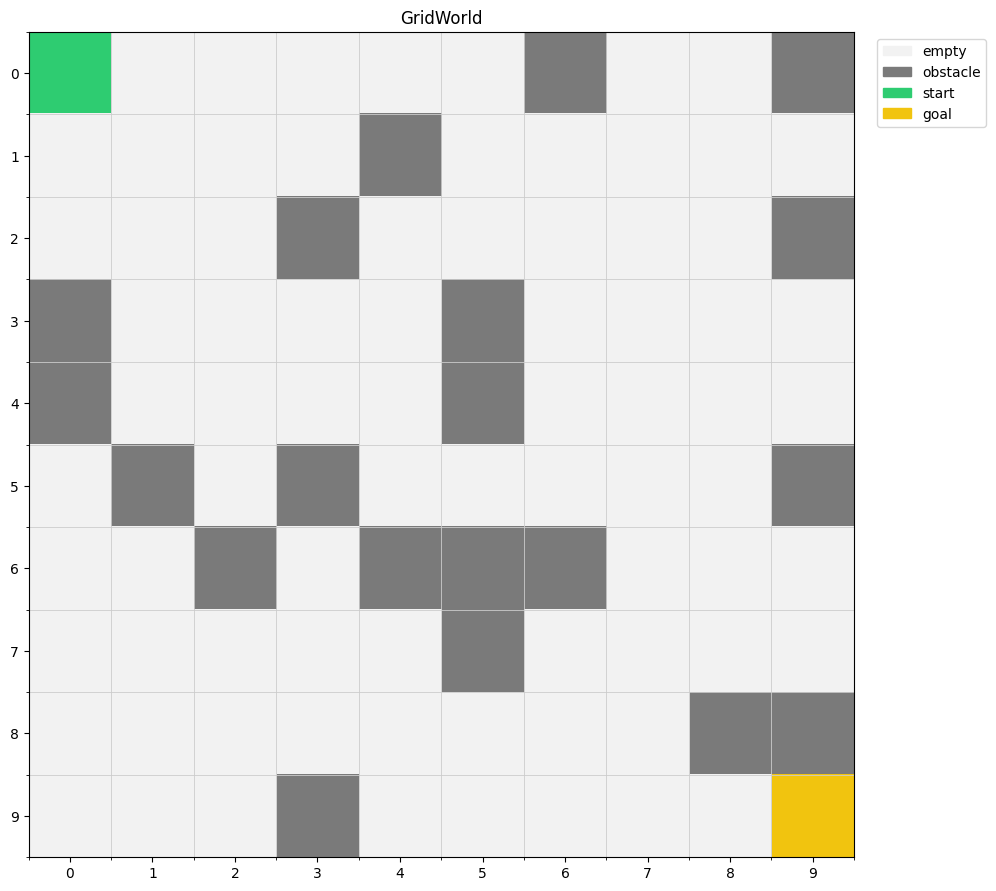

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.patches as mpatches

# --- Config ---
GRID_H, GRID_W = 10, 10
OBSTACLE_RATIO = 0.20
RANDOM_SEED = 48
START = (0, 0)
GOAL  = (GRID_H-1, GRID_W-1)

rng = np.random.default_rng(RANDOM_SEED)

# --- Build numeric grid for generation (0 empty, 1 obstacle, 2 start, 3 goal) ---
grid_num = np.zeros((GRID_H, GRID_W), dtype=int)
num_obstacles = int(OBSTACLE_RATIO * GRID_H * GRID_W)
cells = [(r, c) for r in range(GRID_H) for c in range(GRID_W) if (r, c) not in [START, GOAL]]
rng.shuffle(cells)
for r, c in cells[:num_obstacles]:
    grid_num[r, c] = 1
grid_num[START] = 2
grid_num[GOAL]  = 3

# --- Make an object-typed grid with semantic labels ---
idx2label = {0: "empty", 1: "obstacle", 2: "start", 3: "goal"}
label2idx = {v: k for k, v in idx2label.items()}

grid_obj = np.empty((GRID_H, GRID_W), dtype=object)
for r in range(GRID_H):
    for c in range(GRID_W):
        grid_obj[r, c] = idx2label[int(grid_num[r, c])]

# --- Colormap for the 4 classes (feel free to change colors) ---
# empty, obstacle, start, goal
cmap = ListedColormap(["#f2f2f2", "#7a7a7a", "#2ecc71", "#f1c40f"])
bounds = np.array([-0.5, 0.5, 1.5, 2.5, 3.5])  # 4 bins
norm = BoundaryNorm(bounds, cmap.N)

def show_grid(grid_obj):
    """Render object-labeled grid with fixed colors and a legend."""
    grid_idx = np.vectorize(label2idx.__getitem__)(grid_obj)

    fig, ax = plt.subplots(figsize=(10, 10))
    im = ax.imshow(grid_idx, cmap=cmap, norm=norm, interpolation="nearest")
    ax.set_title("GridWorld")

    # Grid lines at cell boundaries
    ax.set_xticks(np.arange(-.5, grid_obj.shape[1], 1), minor=True)
    ax.set_yticks(np.arange(-.5, grid_obj.shape[0], 1), minor=True)
    ax.grid(which='minor', linewidth=0.6, color='#cccccc')
    ax.set_xticks(range(grid_obj.shape[1]))
    ax.set_yticks(range(grid_obj.shape[0]))

    handles = [
        mpatches.Patch(color=cmap(label2idx["empty"]),    label="empty"),
        mpatches.Patch(color=cmap(label2idx["obstacle"]), label="obstacle"),
        mpatches.Patch(color=cmap(label2idx["start"]),    label="start"),
        mpatches.Patch(color=cmap(label2idx["goal"]),     label="goal"),
    ]
    ax.legend(handles=handles, loc="upper left", bbox_to_anchor=(1.02, 1.0))
    plt.tight_layout()
    plt.show()

show_grid(grid_obj)


In [3]:
from dataclasses import dataclass

@dataclass
class Config:
    slip_prob: float = 0.15          # action noise (0 = deterministic)
    max_steps: int = 200            # episode step cap

    # Rewards
    step_penalty: float = -1        # per-step cost
    bump_penalty: float = -10.0     # hitting wall/obstacle (stay put)
    goal_reward: float = 20.0       # reaching goal
    shaping_coef: float = 0.15      # set >0 to reward progress (Δ Manhattan); 0 = off

    # Q-learning
    episodes: int = 3000            # training episodes
    alpha: float = 0.15             # learning rate
    gamma: float = 0.95             # discount

    # Exploration (constant epsilon)
    epsilon: float = 0.10           # exploration rate (fixed)

    # Reproducibility
    seed: int = RANDOM_SEED         # RNG seed

cfg = Config()

def manhattan(a, b):
    """Manhattan distance between two (row, col) states."""
    return abs(a[0]-b[0]) + abs(a[1]-b[1])

print(cfg)
print("Constant epsilon:", cfg.epsilon)


Config(slip_prob=0.15, max_steps=200, step_penalty=-1, bump_penalty=-10.0, goal_reward=20.0, shaping_coef=0.15, episodes=3000, alpha=0.15, gamma=0.95, epsilon=0.1, seed=48)
Constant epsilon: 0.1


In [4]:
def is_valid(state):
    """Check if state is within grid and not an obstacle."""
    r, c = state
    return 0 <= r < GRID_H and 0 <= c < GRID_W and grid_num[r, c] != 1

def get_reward(state, next_state):
    """Compute reward for transitioning from state to next_state."""
    if next_state == GOAL:
        return cfg.goal_reward
    if not is_valid(next_state) or next_state == state:
        return cfg.bump_penalty
    reward = cfg.step_penalty
    if cfg.shaping_coef > 0:
        # Reward progress towards goal
        reward += cfg.shaping_coef * (manhattan(state, GOAL) - manhattan(next_state, GOAL))
    return reward

def get_next_state(state, action):
    """Get next state given current state and action, considering slip probability."""
    if rng.random() < cfg.slip_prob:
        action = rng.choice(['up', 'down', 'left', 'right'])  # slip to random action

    r, c = state
    if action == 'up':
        next_state = (r-1, c)
    elif action == 'down':
        next_state = (r+1, c)
    elif action == 'left':
        next_state = (r, c-1)
    elif action == 'right':
        next_state = (r, c+1)
    else:
        raise ValueError("Invalid action")

    if is_valid(next_state):
        return next_state
    else:
        return state  # stay put if hitting wall/obstacle
    
ACTIONS = ['up', 'down', 'left', 'right']
ACTION_IDX = {a: i for i, a in enumerate(ACTIONS)}

def choose_action(state, Q, epsilon):
    """Epsilon-greedy action selection."""
    if rng.random() < epsilon:
        return rng.choice(ACTIONS)  # explore
    else:
        r, c = state
        q_values = Q[r, c]
        max_q = np.max(q_values)
        best_actions = [a for a, q in zip(ACTIONS, q_values) if q == max_q]
        return rng.choice(best_actions)  # exploit

In [5]:
## The Bellman equation
def q_learning():
    # Initialize Q-table
    Q = np.zeros((GRID_H, GRID_W, len(ACTIONS)))

    episode_rewards = []

    for ep in range(cfg.episodes):
        state = START
        total_reward = 0
    
        for step in range(cfg.max_steps):
            action = choose_action(state, Q, cfg.epsilon)
            next_state = get_next_state(state, action)
            reward = get_reward(state, next_state)

            r, c = state
            a_idx = ACTION_IDX[action]
            r_next, c_next = next_state

            # Q-learning update
            best_next_q = np.max(Q[r_next, c_next])
            Q[r, c, a_idx] += cfg.alpha * (reward + cfg.gamma * best_next_q - Q[r, c, a_idx])

            state = next_state
            total_reward += reward

            if state == GOAL:
                break

        episode_rewards.append(total_reward)

        if (ep+1) % 500 == 0 or ep == 0:
            print(f"Episode {ep+1}/{cfg.episodes}, Total Reward: {total_reward}")

    return Q, episode_rewards

Episode 1/3000, Total Reward: -468.49999999999994
Episode 500/3000, Total Reward: 1.5500000000000007
Episode 1000/3000, Total Reward: -22.450000000000017
Episode 1500/3000, Total Reward: -30.450000000000017
Episode 2000/3000, Total Reward: -10.450000000000014
Episode 2500/3000, Total Reward: -26.450000000000017
Episode 3000/3000, Total Reward: -6.4500000000000135
Final Q-table shape: (10, 10, 4)
Q-values at START: [-14.84231442  -9.05483455 -18.12133783 -10.35489478]
Q-values at GOAL: [0. 0. 0. 0.]


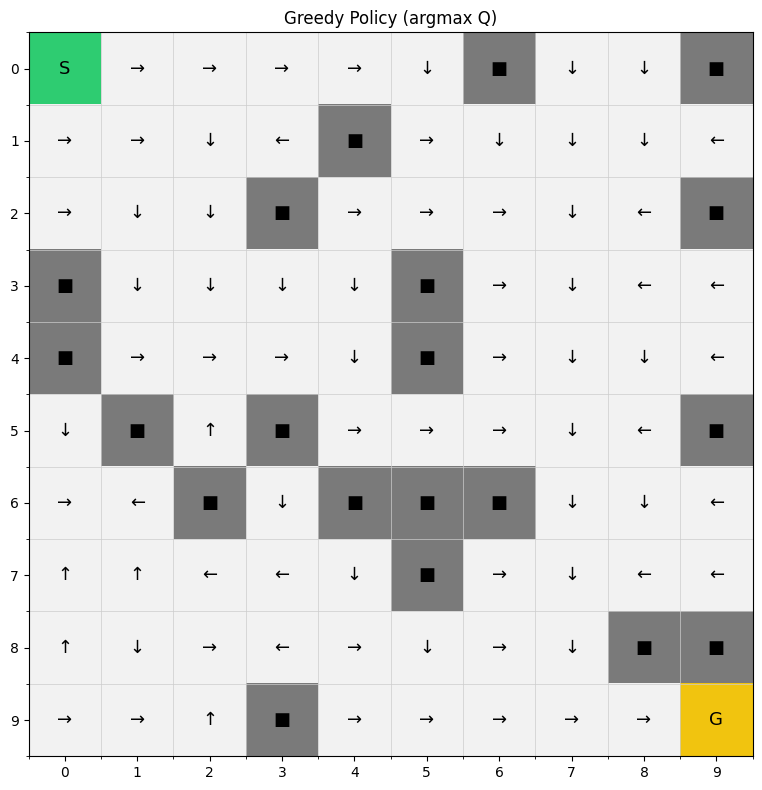

In [7]:
# --- Run Q-learning ---
Q, episode_rewards = q_learning()

# --- Inspect a couple of states ---
print("Final Q-table shape:", Q.shape)
print("Q-values at START:", Q[START[0], START[1]])  # Q[r, c, :]
print("Q-values at GOAL:",  Q[GOAL[0],  GOAL[1]])

# Map action index -> arrow
idx2arrow = {'up': '↑', 'down': '↓', 'left': '←', 'right': '→'}

def _show_background(ax):
    try:
        bg = np.vectorize(label2idx.__getitem__)(grid_obj)
        ax.imshow(bg, cmap=cmap, norm=norm, interpolation="nearest", origin='upper')
    except NameError:
        ax.imshow(grid_num, interpolation="nearest", origin='upper')

fig, ax = plt.subplots(figsize=(8, 8))
_show_background(ax)

# grid lines
ax.set_xticks(np.arange(-.5, GRID_W, 1), minor=True)
ax.set_yticks(np.arange(-.5, GRID_H, 1), minor=True)
ax.grid(which='minor', linewidth=0.5, color='#cccccc')
ax.set_xticks(range(GRID_W))
ax.set_yticks(range(GRID_H))
# ax.invert_yaxis()

for r in range(GRID_H):
    for c in range(GRID_W):
        if grid_num[r, c] == 1:
            txt = "■"              # obstacle
        elif (r, c) == START:
            txt = "S"
        elif (r, c) == GOAL:
            txt = "G"
        else:
            best_a_idx = int(np.argmax(Q[r, c]))
            best_action = ACTIONS[best_a_idx]
            txt = idx2arrow[best_action]
        ax.text(c, r, txt, ha="center", va="center", fontsize=13)

ax.set_title("Greedy Policy (argmax Q)")
plt.tight_layout()
plt.show()


The image here shows the final policies learned after the Bellman equation converges. We can see that the MDP is solved!!